In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
conn = sqlite3.connect('../db.sqlite')
cur = conn.cursor()

# get data by joining game and mldata tables
games = cur.execute("""
                    SELECT Games.home_points, Games.away_points,
                    Games.home_pregame_elo, Games.away_pregame_elo, MLData.*
                    FROM Games JOIN MLData on Games.id = MLData.game_id""").fetchall()
conn.close()

In [3]:
games_df = pd.DataFrame(games)
# games_norm = games_df.drop(games_df.columns[[2,3]], axis=1)
# games_norm = (games_norm-games_norm.min())/(games_norm.max()-games_norm.min())
# games_final = games_norm
games_df["error"] = games_df.iloc[:,1] - games_df.iloc[:,0] - round((games_df.iloc[:,3] - games_df.iloc[:,2])/25)
games_df["home_point_diff"] = games_df.iloc[:,35:49].mean(axis=1) - games_df.iloc[:,49:63].mean(axis=1)
games_df["away_point_diff"] = games_df.iloc[:,148:162].mean(axis=1) - games_df.iloc[:,162:176].mean(axis=1)
games_df["point_diff_diff"] = games_df["home_point_diff"] - games_df["away_point_diff"]
games_df["home_turnover_diff"] = games_df.iloc[:,91:105].mean(axis=1) - games_df.iloc[:,105:119].mean(axis=1)
games_df["away_turnover_diff"] = games_df.iloc[:,204:218].mean(axis=1) - games_df.iloc[:,218:232].mean(axis=1)
games_df["turnover_diff_diff"] = games_df["home_turnover_diff"] - games_df["away_turnover_diff"]
games_df["home_yard_diff"] = games_df.iloc[:,63:77].mean(axis=1) - games_df.iloc[:,77:91].mean(axis=1)
games_df["away_yard_diff"] = games_df.iloc[:,176:190].mean(axis=1) - games_df.iloc[:,190:204].mean(axis=1)
games_df["yard_diff_diff"] = games_df["home_yard_diff"] - games_df["away_yard_diff"]
games_df["home_elo_diff"] = games_df.iloc[:,7:21].mean(axis=1) - games_df.iloc[:,21:35].mean(axis=1)
games_df["away_elo_diff"] = games_df.iloc[:,120:134].mean(axis=1) - games_df.iloc[:,134:148].mean(axis=1)
games_df["elo_diff_diff"] = games_df["home_elo_diff"] - games_df["away_elo_diff"]
games_df["pred_spread"] = (games_df.iloc[:, 3] - games_df.iloc[:, 2])/25
# games_norm = games_df.drop(games_df.columns[[0,1,2,3]], axis=1)
# games_norm = (games_norm-games_norm.min())/(games_norm.max()-games_norm.min())
# games_final = pd.concat((games_df.iloc[:,:2], games_norm), axis=1)
games_final = games_df

In [4]:
games_final

,0,1,2,3,4,5,6,7,8,9,...,home_turnover_diff,away_turnover_diff,turnover_diff_diff,home_yard_diff,away_yard_diff,yard_diff_diff,home_elo_diff,away_elo_diff,elo_diff_diff,pred_spread
0,42,34,1557,1453,1,268,1557,1454,1624,1581,...,0.500000,-0.500000,1.000000,-3.500000,2.785714,-6.285714,153.928571,47.857143,106.071429,-4.16
1,13,31,1563,1447,2,269,1563,1554,1519,1504,...,0.285714,0.000000,0.285714,9.357143,-2.785714,12.142857,31.785714,68.357143,-36.571429,-4.64
2,34,7,1556,1454,3,270,1556,1556,1570,1664,...,0.000000,0.428571,-0.428571,10.285714,17.857143,-7.571429,139.500000,84.000000,55.500000,-4.08
3,16,14,1555,1455,4,271,1555,1559,1511,1537,...,0.285714,-1.142857,1.428571,-13.928571,44.000000,-57.928571,71.357143,55.785714,15.571429,-4.00
4,35,7,1554,1456,5,272,1554,1456,1494,1560,...,-0.071429,0.000000,-0.071429,31.142857,25.714286,5.428571,79.928571,112.000000,-32.071429,-3.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,23,34,1378,1705,2684,3444,1378,1783,1453,1513,...,-0.285714,0.214286,-0.500000,23.071429,34.642857,-11.571429,74.071429,65.642857,8.428571,13.08
2684,17,14,1535,1452,2685,3445,1535,1544,1554,1445,...,0.285714,-0.428571,0.714286,-7.214286,-52.500000,45.285714,-51.428571,75.714286,-127.142857,-3.32
2685,12,20,1660,1364,2686,3446,1660,1352,1556,1503,...,0.142857,-0.071429,0.214286,-0.571429,-36.857143,36.285714,-87.214286,20.857143,-108.071429,-11.84
2686,30,24,1504,1525,2687,3447,1504,1316,1456,1561,...,-0.357143,0.142857,-0.500000,3.714286,12.928571,-9.214286,-60.142857,-21.285714,-38.857143,0.84


In [5]:
class GameDataset(Dataset):
    def __init__(self, games, transform=None, target_transform=None):
        self.labels = (games.iloc[:, 1] - games.iloc[:, 0]).to_numpy()
        # self.labels = games["error"].to_numpy()
        self.input = games[["elo_diff_diff","point_diff_diff","yard_diff_diff","turnover_diff_diff","pred_spread"]].to_numpy()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        label = self.labels[index:index+1]
        model_input = self.input[index]
        if self.transform:
            model_input = self.transform(model_input, dtype=torch.float32)
        if self.target_transform:
            label = self.target_transform(label, dtype=torch.float32)
        return model_input, label#, self.spread[index]
    
dataset = GameDataset(games_final, torch.tensor, torch.tensor)
gen1 = torch.Generator().manual_seed(42)
train, test = random_split(dataset, [0.7, 0.3], generator=gen1)

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

In [8]:
test_input = torch.tensor(games_final[["elo_diff_diff","point_diff_diff","yard_diff_diff","turnover_diff_diff","pred_spread"]].to_numpy()[0],
                          dtype=torch.float32)

In [9]:
test_input

tensor([-1.0987e+03,  6.3571e+00, -6.2857e+00,  1.0000e+00, -4.1600e+00])

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# build the network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

Using cpu device


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    loss_arr = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropogate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_arr.append(loss.item())

        # if batch % 20 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return np.mean(loss_arr)

def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    loss = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss = loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss.append(test_loss)

    return np.mean(loss)
    # test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
model = NeuralNetwork()
learning_rate = 1e-3
batch_size = 64
epochs = 40
loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
loss = []
val_loss = []
for t in range(epochs):
    loss.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    val_loss.append(test_loop(test_dataloader, model, loss_fn))

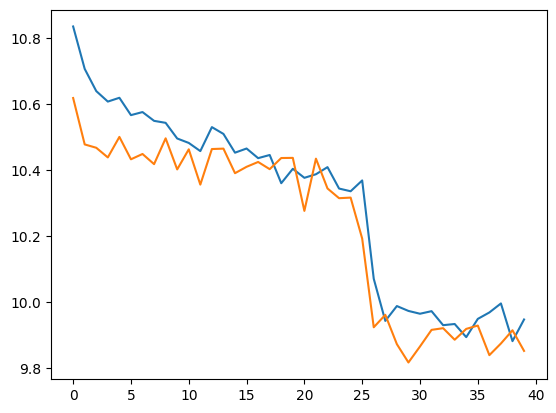

In [10]:
%matplotlib inline
plt.clf()
plt.plot(loss)
plt.plot(val_loss);
plt.show()

In [55]:
games_df["error"].mean()

2.3273809523809526

In [14]:
actual = np.array([])
predicted = np.array([])
elo_pred = np.array([])
model.eval()
for feature, label in test_dataloader:
    # predicted = np.concatenate((predicted, model(feature).detach().numpy().ravel()))
    predicted = np.concatenate((predicted, 
                                model(feature).detach().numpy().ravel()))
    actual = np.concatenate((actual, label.detach().numpy().ravel()))
    elo_pred = np.concatenate((elo_pred, feature[:,-1].detach().numpy().ravel()))

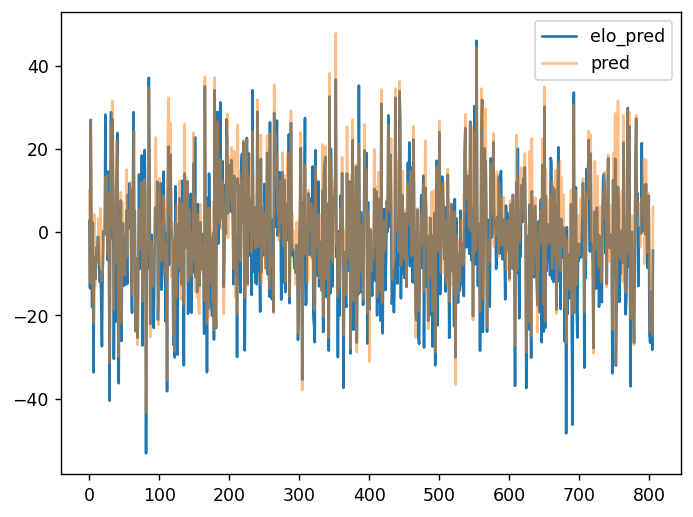

In [19]:
%matplotlib inline
plt.clf()
# plt.plot(actual, label='actual')
plt.plot(elo_pred - actual, label='elo_pred')
plt.plot(predicted - actual, label='pred', alpha=0.5)
plt.legend()
plt.show()

In [20]:
print(np.mean(np.abs(elo_pred - actual)))
print(np.mean(np.abs(predicted - actual)))

11.776923072424998
10.371295747959584


In [21]:
torch.save(model.state_dict(), '../models/v1.pth')

In [41]:
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
input_data = train_features[0:1]
label = train_labels[0]
print(f"input_data: {input_data}")
print(f"Label: {label}")
pred = model(input_data)
print(f"pred: {pred}")

Feature batch shape: torch.Size([64, 5])
Labels batch shape: torch.Size([64, 1])
input_data: tensor([[-118.4286,   -4.9286,  -41.2857,   -0.2857,   11.4000]])
Label: tensor([-3.])
pred: tensor([[4.0849]], grad_fn=<AddmmBackward0>)


In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load('../models/v1.pth'))
model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [12]:
model(test_input)

tensor([-4.2387], grad_fn=<AddBackward0>)